In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [86]:
pd.set_option('display.max_columns', None)

In [87]:
data_path = Path("../data")

In [88]:
df_final = pd.read_parquet(data_path / "full_data.parquet")

In [89]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 69 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_unique_published_ads                    56335 non-null  int64    
 4   monthly_contracted_ads                          56335 non-null  int64    
 5   monthly_leads                                   56335 non-null  int64    
 6   monthly_visits                                  56335 non-null  float64  
 7   monthly_oro_ads                                 56335 non-null  int64    
 8   monthly_plata_ads                               56335 non-null  int64    
 9   monthly_destacados_ads

In [90]:
df_final.sample(5)

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,monthly_total_phone_views,monthly_total_calls,monthly_total_emails,monthly_total_invoice,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,monthly_avg_ad_price,monthly_distinct_ads,month_period,churn,tenure,months_since_last_contract,has_renewed,monthly_total_premium_ads,ratio_published_contracted,ratio_unique_published,ratio_premium_ads,leads_per_published_ad,leads_per_premium_ad,visits_per_published_ad,leads_per_visit,leads_per_shows,invoice_per_published_ad,invoice_per_lead,monthly_leads_3_months_mean,monthly_leads_3_months_mean_delta,monthly_visits_3_months_mean,monthly_visits_3_months_mean_delta,monthly_total_invoice_3_months_mean,monthly_total_invoice_3_months_mean_delta,monthly_avg_ad_price_3_months_mean,monthly_avg_ad_price_3_months_mean_delta,monthly_published_ads_3_months_mean,monthly_published_ads_3_months_mean_delta,monthly_contracted_ads_3_months_mean,monthly_contracted_ads_3_months_mean_delta,ratio_published_contracted_3_months_mean,ratio_published_contracted_3_months_mean_delta,ratio_unique_published_3_months_mean,ratio_unique_published_3_months_mean_delta,ratio_premium_ads_3_months_mean,ratio_premium_ads_3_months_mean_delta,leads_per_published_ad_3_months_mean,leads_per_published_ad_3_months_mean_delta,leads_per_premium_ad_3_months_mean,leads_per_premium_ad_3_months_mean_delta,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta
29522,2203,202312,46,46,50,50,146137.5,1,1,1,0,854889.0,29,22,15,199.7,15,25,40,9350.28,63.0,2023-12,0.0,24.0,24.0,0,3,0.920000,1.0,0.065217,1.086957,16.666667,3176.902174,0.000342,0.000058,4.341304,3.994000,70.666667,-20.666667,167645.00,-21507.50,199.700000,0.000000,10319.340000,-969.060000,51.666667,-5.666667,54.0,-4.0,0.955476,-0.035476,1.0,0.0,0.058464,0.006753,1.356254,-0.269298,23.555556,-6.888889,3244.225141,-67.322967,0.000416,-0.000074,0.000065,-0.000006,3.891767,0.449538,2.987322,1.006678
51023,2280,202410,0,0,14,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,NaN,NaN,2024-10,0.0,55.0,55.0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,-0.333333,2.50,-2.50,0.000000,0.000000,NaN,NaN,0.000000,0.000000,14.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22526,1397,202309,215,215,400,106,181515.0,7,7,3,0,2405844.0,22,37,21,85.7,27,53,80,39787.50,12.0,2023-09,0.0,1.0,1.0,1,17,0.537500,1.0,0.079070,0.493023,6.235294,844.255814,0.000584,0.000044,0.398605,0.808491,97.000000,9.000000,157278.75,24236.25,85.700000,0.000000,34863.750000,4923.750000,208.500000,6.500000,400.0,0.0,0.521250,0.016250,1.0,0.0,0.081614,-0.002544,0.464333,0.028690,5.705882,0.529412,751.441026,92.814788,0.000623,-0.000039,0.000039,0.000005,0.411431,-0.012826,0.891177,-0.082687
12156,513,202305,4,4,35,2,9495.0,0,0,0,0,34671.0,1,0,2,21.2,0,2,2,39850.00,4.0,2023-05,0.0,38.0,38.0,0,0,0.114286,1.0,0.000000,0.500000,0.000000,2373.750000,0.000211,0.000058,5.300000,10.600000,4.333333,-2.333333,8715.00,780.00,22.266667,-1.066667,39850.000000,0.000000,4.000000,0.000000,35.0,0.0,0.114286,0.000000,1.0,0.0,0.000000,0.000000,1.083333,-0.583333,0.000000,0.000000,2178.750000,195.000000,0.000510,-0.000299,0.000210,-0.000153,5.566667,-0.266667,6.321111,4.278889
36045,2107,202403,60,60,75,49,137317.5,1,1,1,0,1681281.0,33,25,13,227.6,14,20,34,8181.53,75.0,2024-03,0.0,38.0,38.0,0,3,0.800000,1.0,0.050000,0.816667,16.333333,2288.625

In [91]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df_final.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [92]:
train_df = df_final[
    (df_final['month_period'] >= '202303') &
    (df_final['month_period'] < '202401')
]

val_df = df_final[df_final['month_period'] == '202401']

In [94]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [95]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [96]:
train_cols = numerical_cols + binary_cols
train_cols = [col for col in train_cols if not df_final[col].isna().any()]

# Ridge Regression

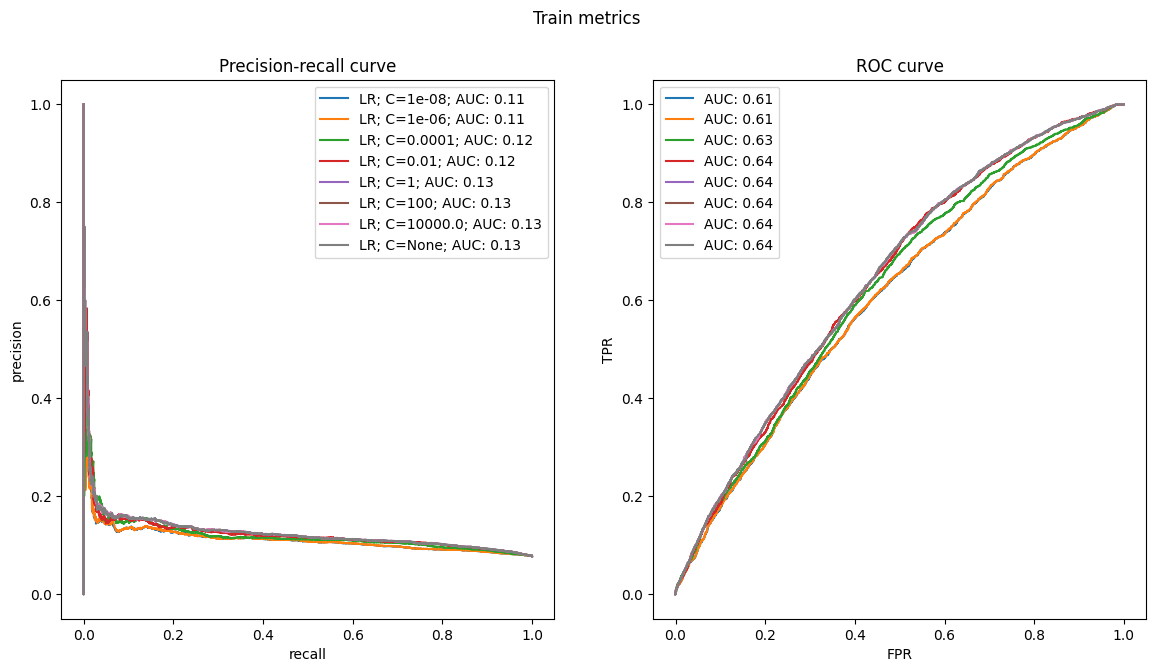

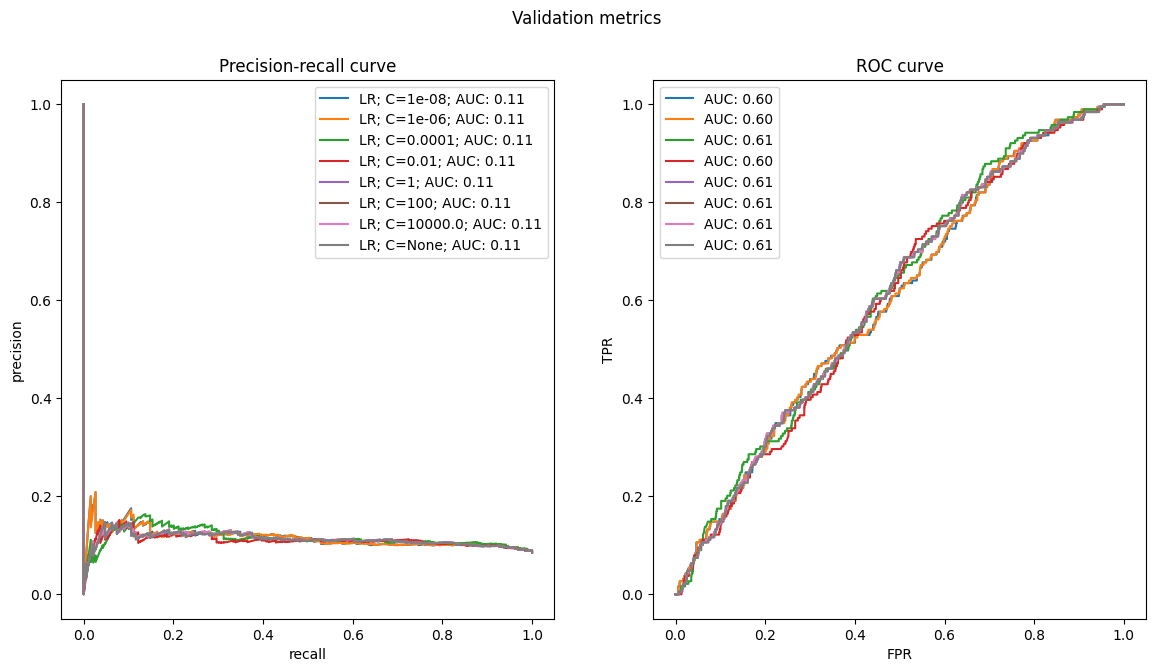

In [97]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



* Los dos modelos con mayor regularización (C= 1e-8 y 1e-6) muestran rendimientos similares en train y en validation. 

* No obstante, la regularización no tiene mucho impacto, ya que el modelo lineal no es capaz de capturar patrones posiblemente no lineales

# Lasso Regression

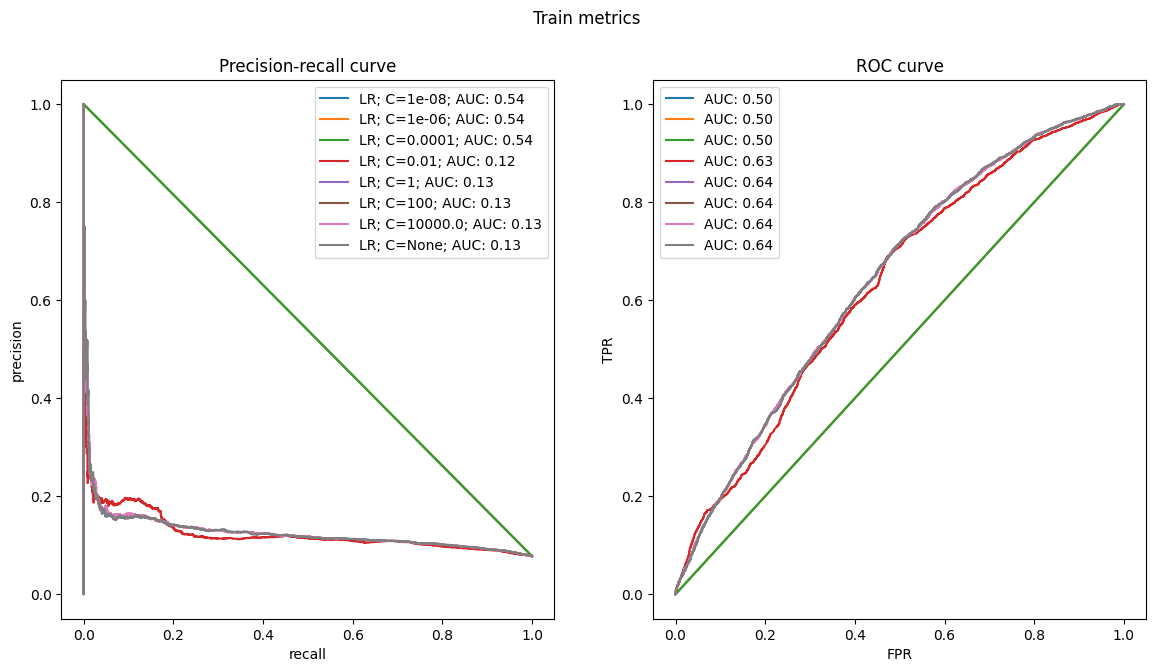

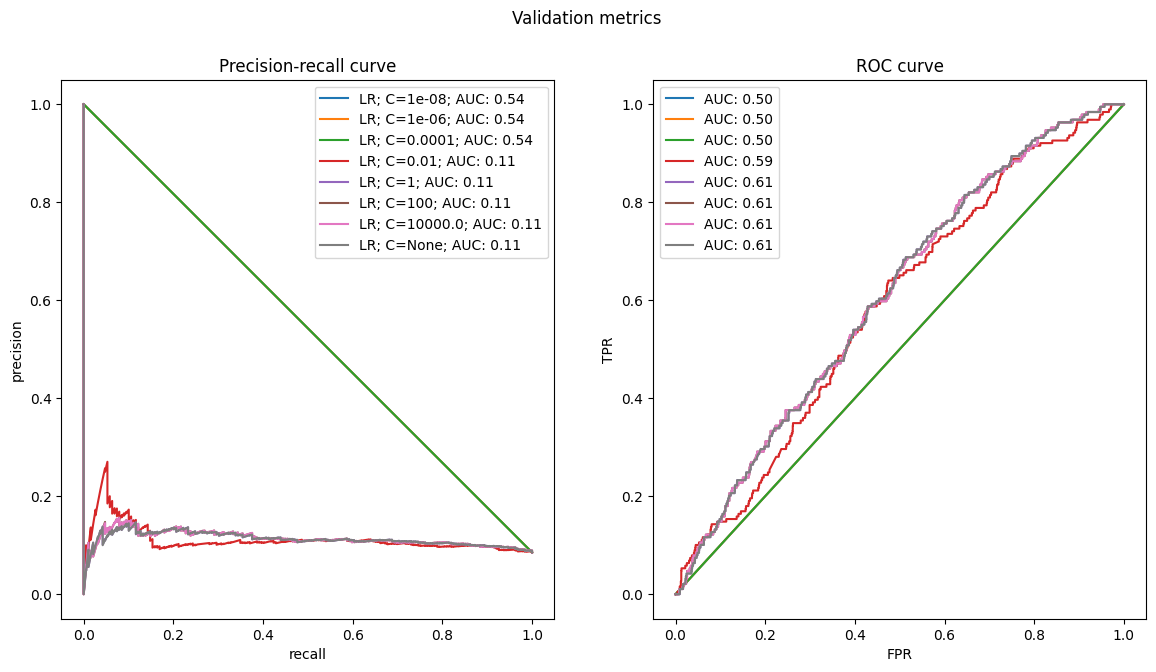

In [98]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l1", C=c if c else 1.0, solver='liblinear'),  # Cambiado a L1 y añadido solver
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

* En este caso el rendimiento en train si que es algo mejor que en validation, hay algo de overfitting.

# Coefficients weights

In [107]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),  #elijo el que parecia que funcionaba mejor
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)


lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-2, solver="saga"),)
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)

lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Axes: xlabel='importance', ylabel='features'>

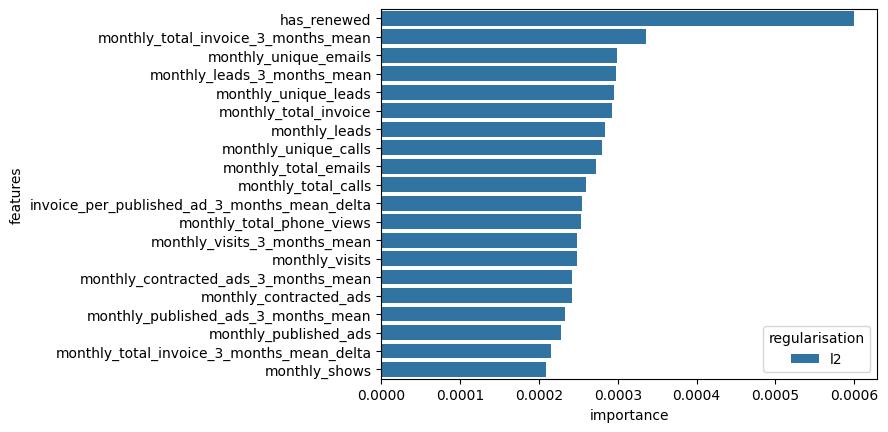

In [113]:
lr_coeff_l2["features"] = pd.Categorical(lr_coeff_l2["features"])
lr_coeff_l2 = lr_coeff_l2.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending = False)["features"]

top_20_features_l2 = lr_coeff_l2.sort_values(by="importance", ascending=False).head(20)

sns.barplot(
    data=top_20_features_l2,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l2["features"]
)

<Axes: xlabel='importance', ylabel='features'>

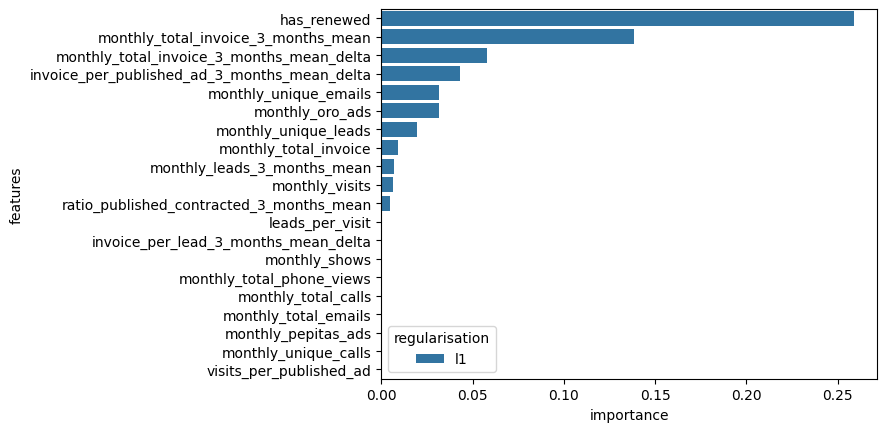

In [114]:
lr_coeff_l1["features"] = pd.Categorical(lr_coeff_l1["features"])
lr_coeff_l1 = lr_coeff_l1.sort_values(by=["importance"])
order_columns = lr_coeff_l1.sort_values(by="importance", ascending = False)["features"]


top_20_features_l1 = lr_coeff_l1.sort_values(by="importance", ascending=False).head(20)


sns.barplot(
    data=top_20_features_l1,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l1["features"]
)

Para Lasso, solo importan las variables

* has_renewed

* monthly_total_invoice_3_months_mean

* monthly_total_invoice_3_months_mean_delta

* invoice_per_published_ad_3_months_mean_delta

* monthly_unique_emails

* monthly_oro_ads

* monthly_unique_leads

* monthly_total_invoice

* monthly_leads_3_months_mean

* monthly_visits

* ratio_published_contracted_3_months_mean

Vamos a probar un modelo con L1 y otro con L2 con estas variables unicamente y si el renidmiento es parecido, nos quedamos como baseline este modelo

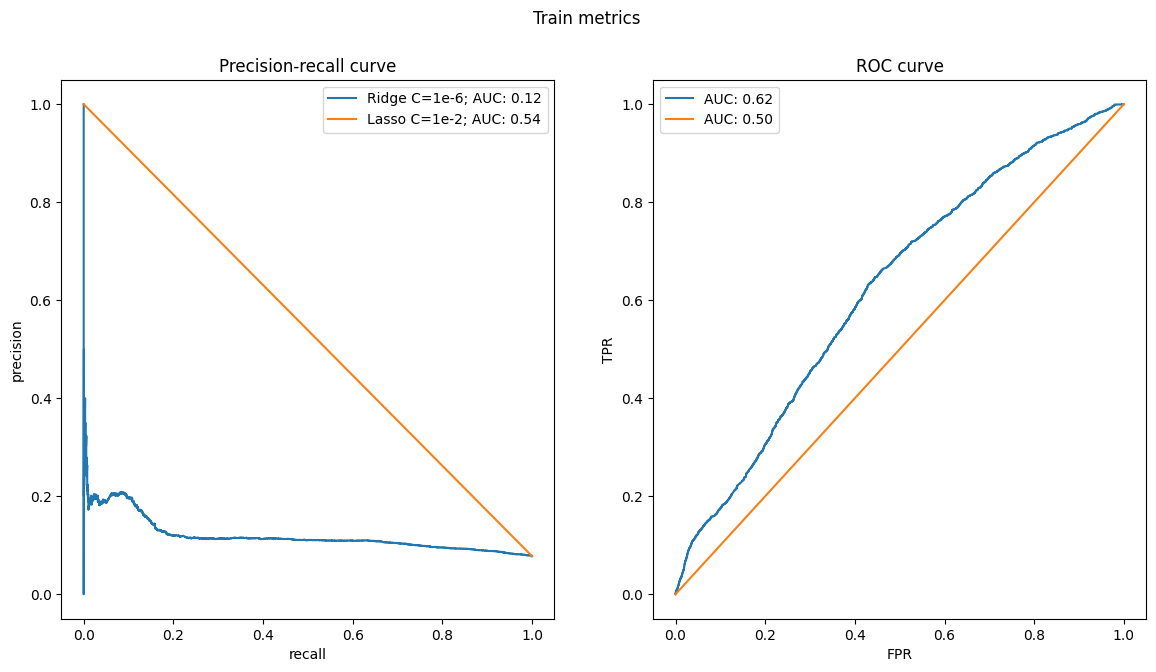

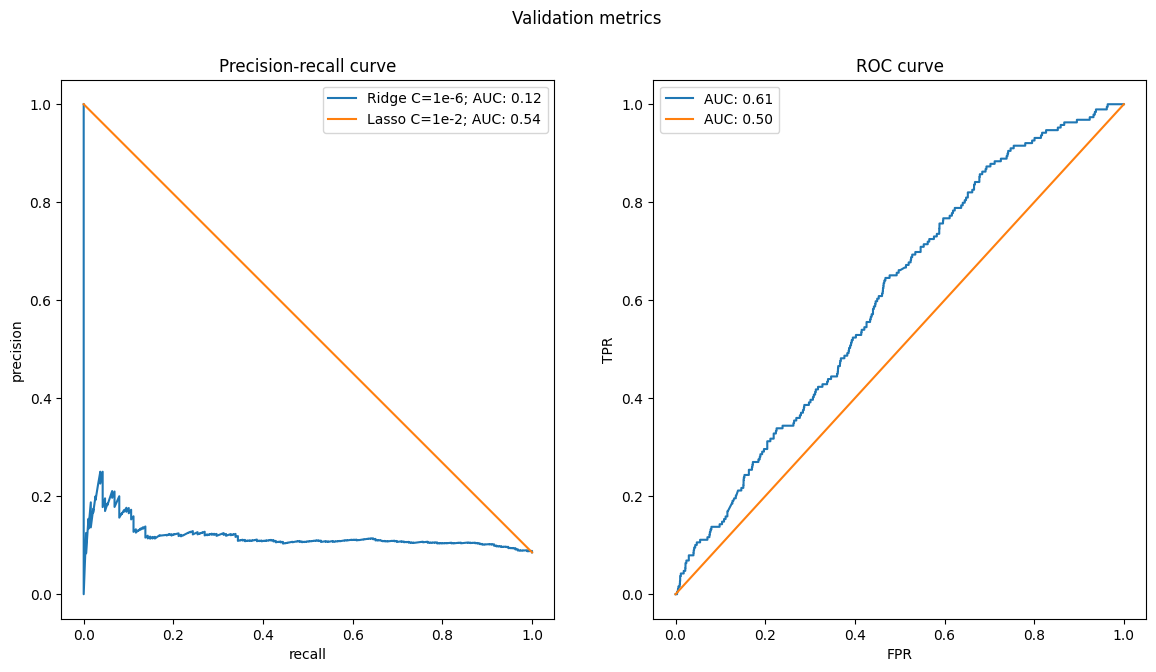

In [116]:
reduced_cols = ["has_renewed", "monthly_total_invoice_3_months_mean", "monthly_total_invoice_3_months_mean_delta", "invoice_per_published_ad_3_months_mean_delta",
 "monthly_unique_emails", "monthly_oro_ads", "monthly_unique_leads", "monthly_total_invoice", "monthly_leads_3_months_mean", "monthly_visits",
"ratio_published_contracted_3_months_mean" ]

fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize= (14,7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga")
    )
]

names = ["Ridge C=1e-6", "Lasso C=1e-2"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



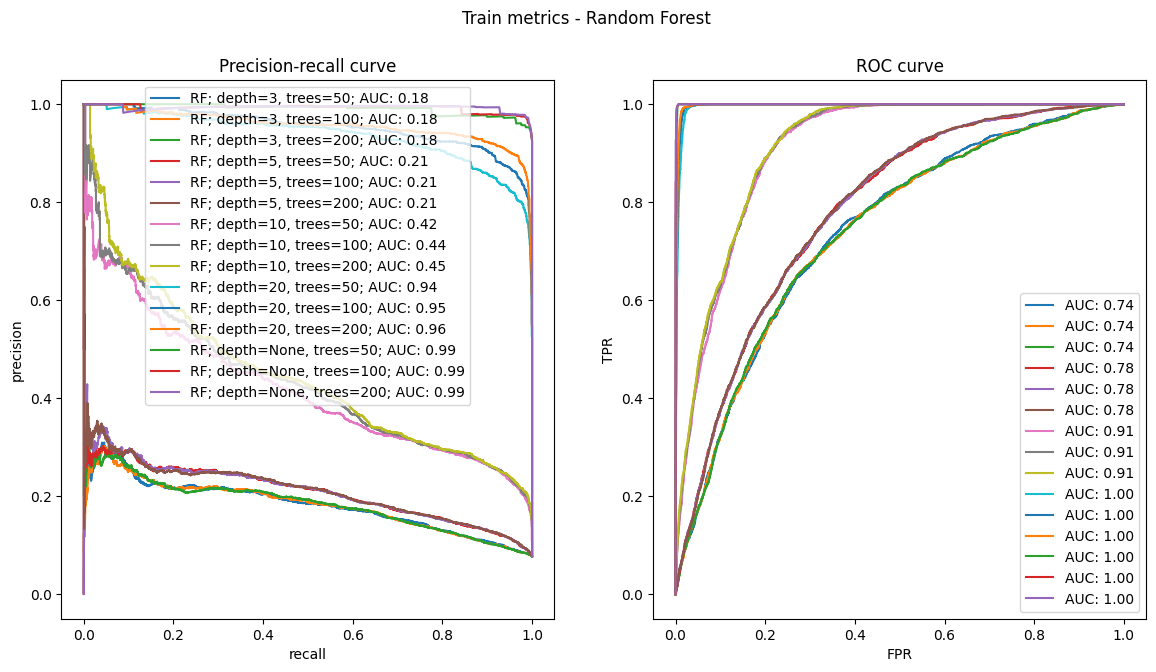

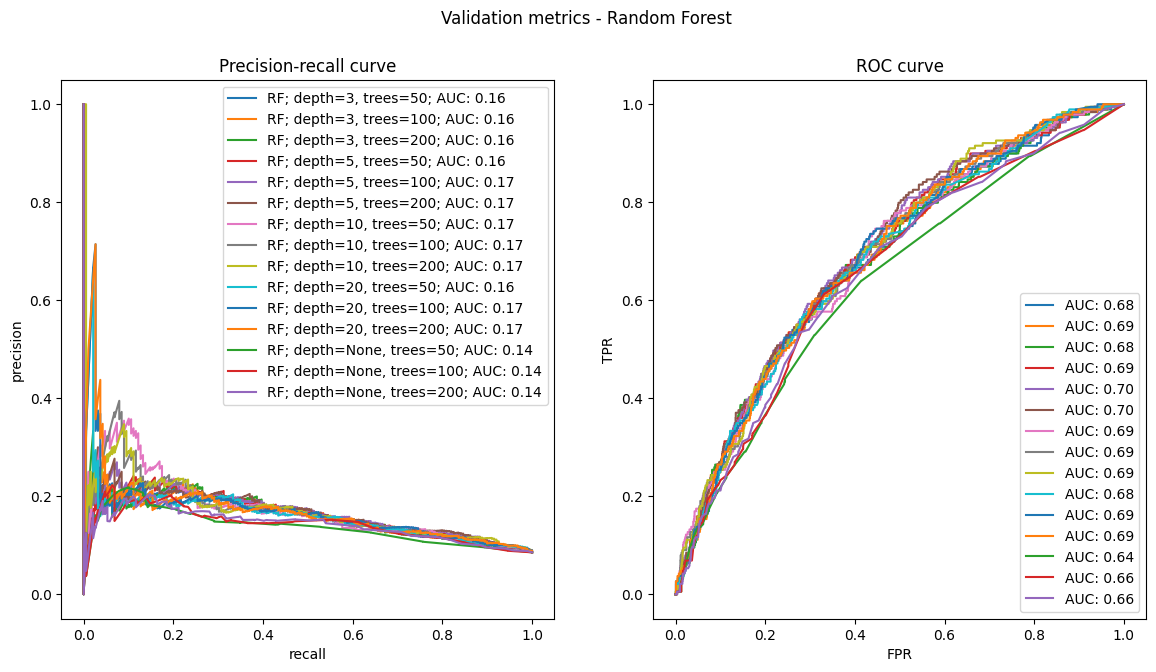

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [3, 5, 10, 20, None]
n_estimators_list = [50, 100, 200]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=42,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[train_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )

